# Importing libraries and loading data

In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings 
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools

pd.set_option('display.max_rows', 1000)

In [2]:
df = pd.read_csv("/kaggle/input/patient-treatment-classification/data-ori.csv").drop_duplicates()
print(df.shape)
df.sample(5).T

(4412, 11)


,3963,1266,2763,1914,386
HAEMATOCRIT,33.2,27.2,38.3,25.4,37.8
HAEMOGLOBINS,10.6,8.5,12.2,8.5,13.1
ERYTHROCYTE,3.46,4.32,4.14,2.95,4.73
LEUCOCYTE,7.3,13.7,5.1,5.2,3.4
THROMBOCYTE,243,346,279,390,140
MCH,30.6,19.7,29.5,28.8,27.7
MCHC,31.9,31.3,31.9,33.5,34.7
MCV,96.0,63.0,92.5,86.1,79.9
AGE,74,32,57,43,16
SEX,M,F,F,M,M


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4412 entries, 0 to 4411
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HAEMATOCRIT   4412 non-null   float64
 1   HAEMOGLOBINS  4412 non-null   float64
 2   ERYTHROCYTE   4412 non-null   float64
 3   LEUCOCYTE     4412 non-null   float64
 4   THROMBOCYTE   4412 non-null   int64  
 5   MCH           4412 non-null   float64
 6   MCHC          4412 non-null   float64
 7   MCV           4412 non-null   float64
 8   AGE           4412 non-null   int64  
 9   SEX           4412 non-null   object 
 10  SOURCE        4412 non-null   object 
dtypes: float64(7), int64(2), object(2)
memory usage: 413.6+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
HAEMATOCRIT,4412.0,38.197688,5.974784,13.70,34.375,38.60,42.50,69.00
HAEMOGLOBINS,4412.0,12.741727,2.079903,3.80,11.400,12.90,14.20,18.90
ERYTHROCYTE,4412.0,4.541260,0.784091,1.48,4.040,4.57,5.05,7.86
LEUCOCYTE,4412.0,8.718608,5.049041,1.10,5.675,7.60,10.30,76.60
THROMBOCYTE,4412.0,257.524479,113.972365,8.00,188.000,256.00,321.00,1183.00
MCH,4412.0,28.234701,2.672639,14.90,27.200,28.70,29.80,40.80
MCHC,4412.0,33.343042,1.228664,26.00,32.700,33.40,34.10,39.00
MCV,4412.0,84.612942,6.859101,54.00,81.500,85.40,88.70,115.60
AGE,4412.0,46.626473,21.731218,1.00,29.000,47.00,64.00,99.00


In [5]:
df['SEX'].value_counts()

M    2290
F    2122
Name: SEX, dtype: int64

# Data transformation

In [6]:
# select label
main_label = 'SOURCE'
df[main_label] = (df[main_label] == 'in').astype(int)
# group age with larger bins
df['AGE'] = df['AGE'].apply(lambda x: 10*round(1/10*x))
# log10-transform columns and group with larger bins
for col in ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCH', 'MCHC', 'MCV']:
    df[f'log10_{col}'] = df[col].apply(lambda x: 1/5*round(5*np.log10(1+x)))
    df = df.drop([col], axis=1)
print(df.shape)
df.sample(5).T

(4412, 11)


,4189,1090,4170,1018,2126
AGE,80,30,80,30,50
SEX,M,F,M,F,F
SOURCE,0,0,1,1,1
log10_HAEMATOCRIT,1.6,1.6,1.4,1.6,1.6
log10_HAEMOGLOBINS,1.2,1.2,1.0,1.2,1.2
log10_ERYTHROCYTE,0.8,0.8,0.6,0.8,0.8
log10_LEUCOCYTE,0.8,0.8,1.2,1.2,0.8
log10_THROMBOCYTE,2.2,2.4,2.4,2.6,2.0
log10_MCH,1.4,1.4,1.4,1.4,1.4
log10_MCHC,1.6,1.6,1.6,1.6,1.6


# Machine learning

In [7]:
# initialize data
y = df[main_label].values.reshape(-1,)
X = df.drop([main_label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2206, 10), (2206, 10), (2206,), (2206,))

In [8]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostClassifier(iterations=1000,
                           depth=5,
                           border_count=23,
                           l2_leaf_reg=0.3,
                           learning_rate=3e-3,
                           verbose=0)

#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict_proba(train_pool)[:,1]
y_test_pred = model.predict_proba(test_pool)[:,1]
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"ROC AUC score for train {round(roc_auc_train,4)}, and for test {round(roc_auc_test,4)}")

ROC AUC score for train 0.7902, and for test 0.7916


In [9]:
# calculating the baseline ROC AUC score assuming the same probability from training labels to test
roc_auc_baseline = roc_auc_score(y_test, [np.mean(y_train)]*len(y_test))
print(roc_auc_baseline)

0.5


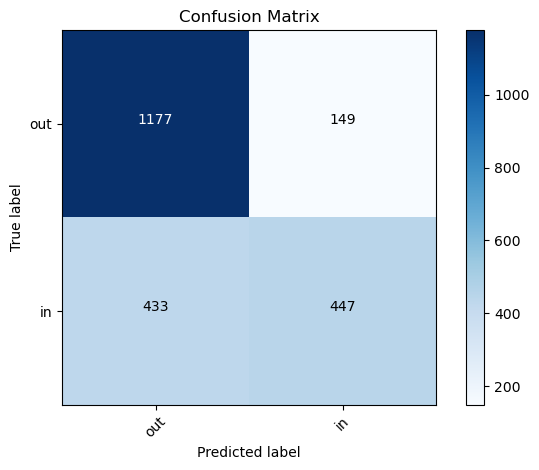

In [10]:
# plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.
    
    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
# Get the confusion matrix
cm = confusion_matrix(y_test, (y_test_pred > 0.5))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Plot the confusion matrix
class_names = ['out', 'in'] # positive class should come the last
plot_confusion_matrix(cm, class_names)

# Explanations with SHAP values

Average treatment probability is 0.3989


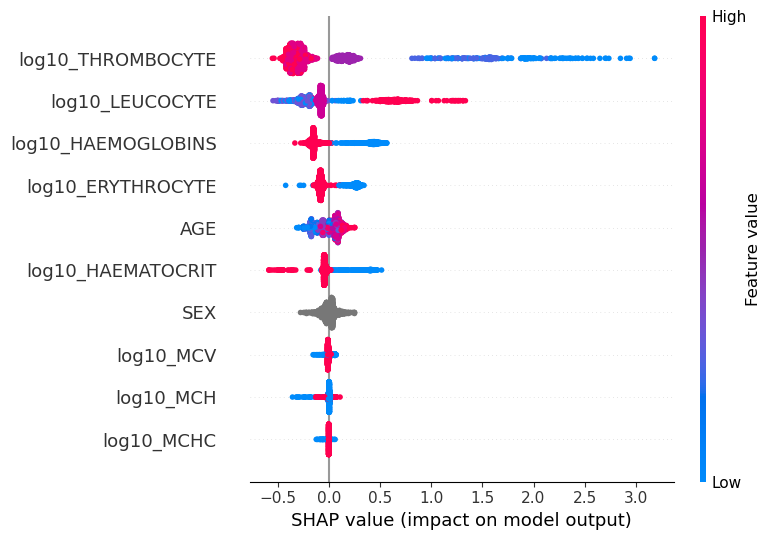

In [11]:
shap.initjs()
ex = shap.TreeExplainer(model)
print(f"Average treatment probability is {round(np.mean(y_test),4)}")
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)


AGE



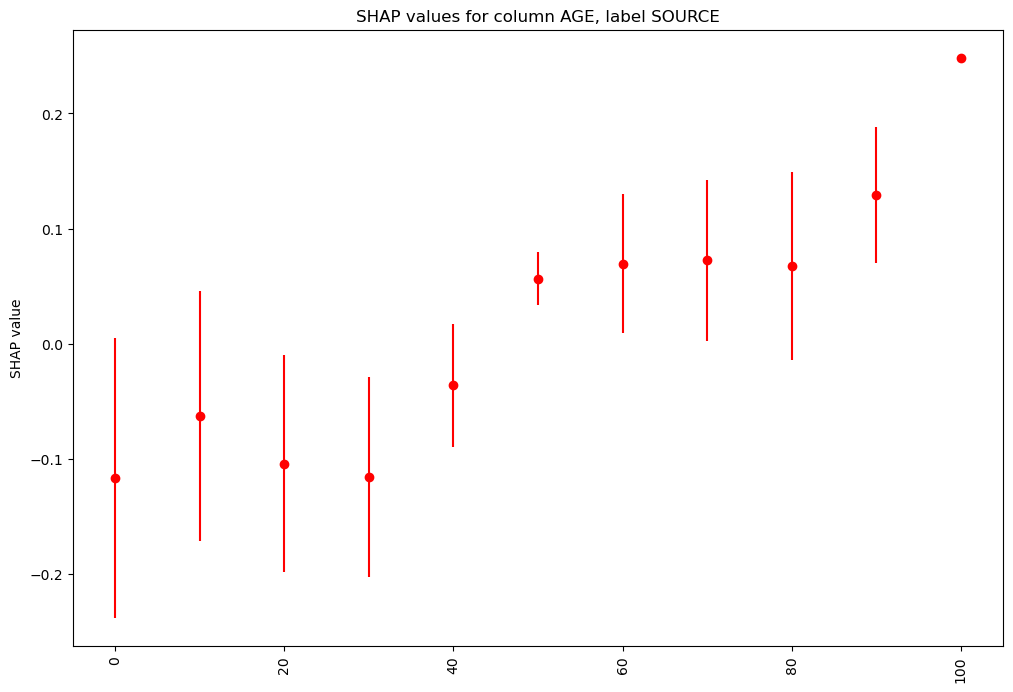

       gain  gain_std  count
col                         
100  0.2484       NaN      1
90   0.1290    0.0592     52
70   0.0723    0.0700    269
60   0.0695    0.0601    387
80   0.0671    0.0816    160
50   0.0564    0.0228    262
40  -0.0360    0.0534    312
10  -0.0627    0.1085    120
20  -0.1044    0.0942    255
30  -0.1157    0.0867    316
0   -0.1165    0.1214     72

SEX



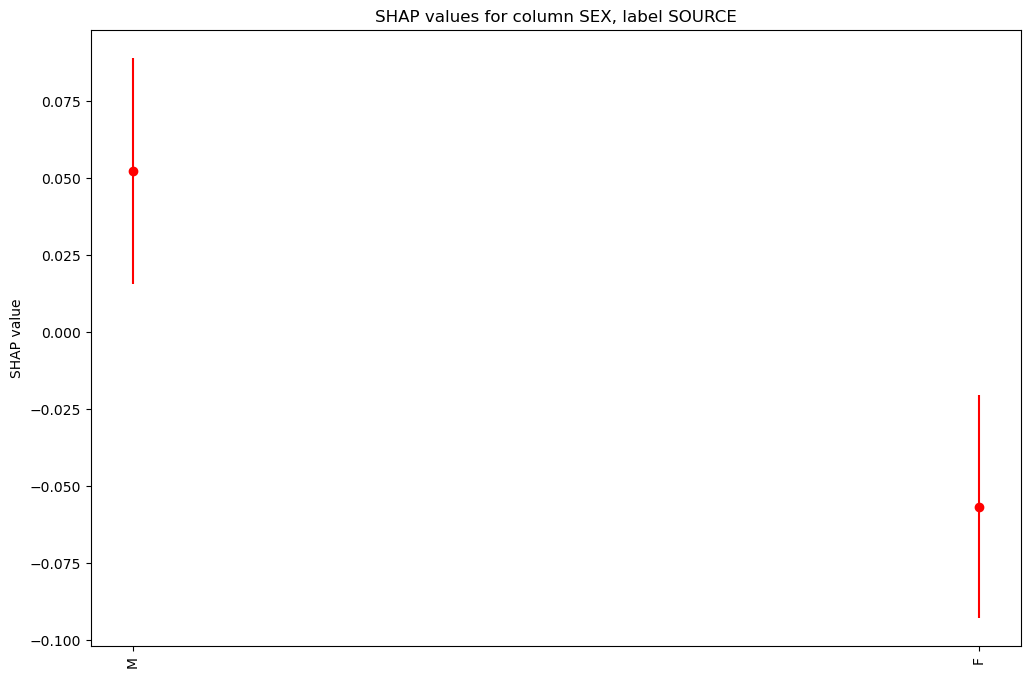

       gain  gain_std  count
col                         
M    0.0523    0.0367   1125
F   -0.0566    0.0362   1081

log10_HAEMATOCRIT



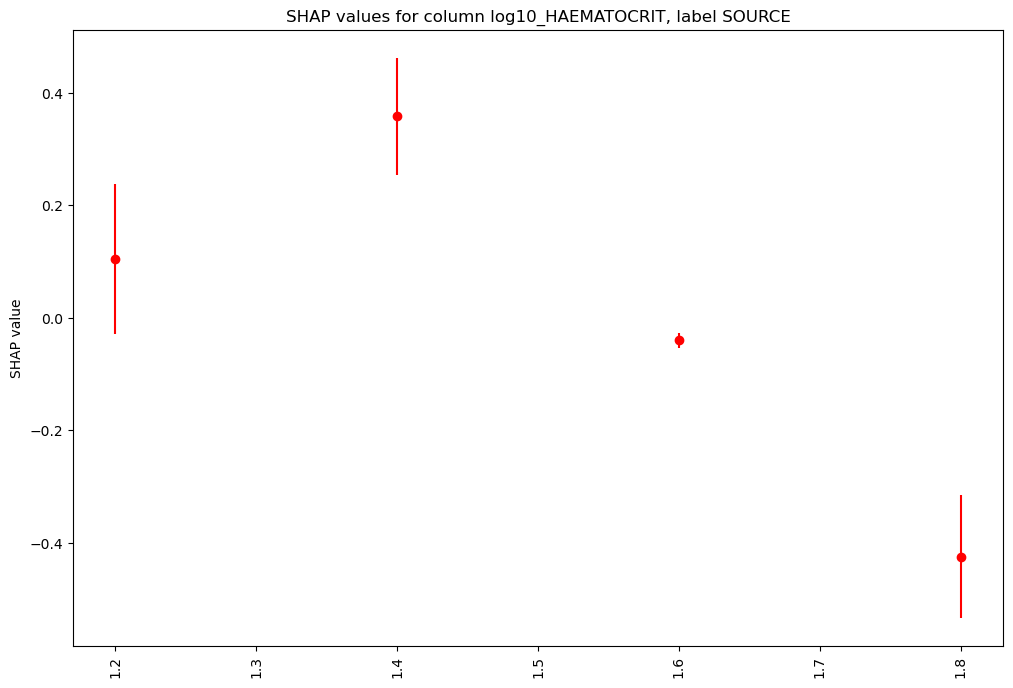

       gain  gain_std  count
col                         
1.4  0.3582    0.1036    262
1.2  0.1039    0.1333      5
1.6 -0.0396    0.0131   1905
1.8 -0.4247    0.1091     34

log10_HAEMOGLOBINS



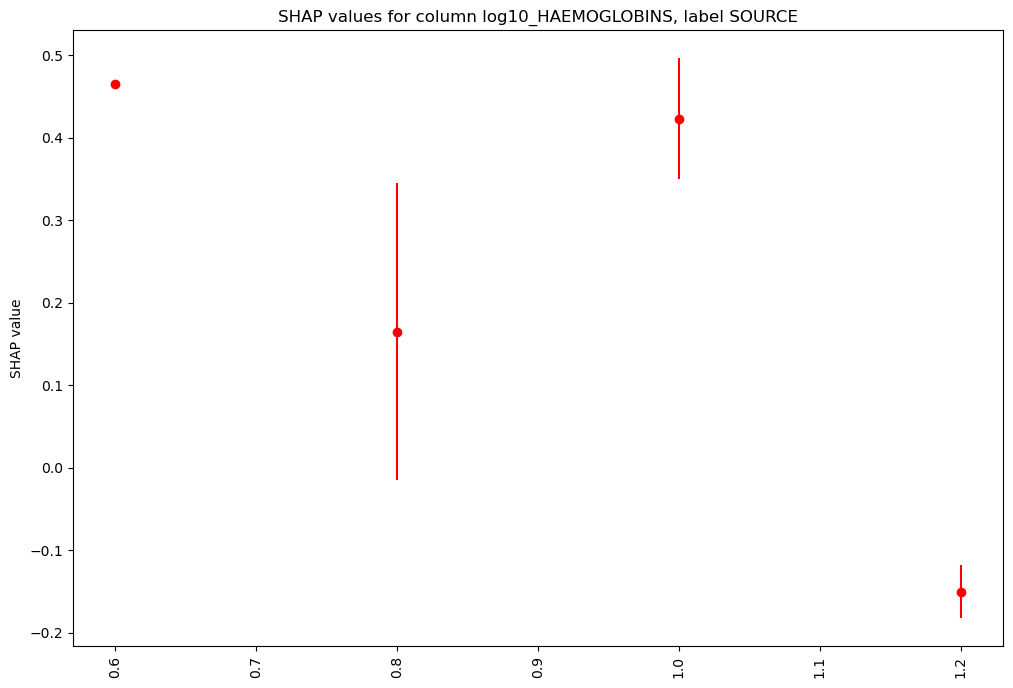

       gain  gain_std  count
col                         
0.6  0.4657       NaN      1
1.0  0.4231    0.0734    601
0.8  0.1650    0.1797     10
1.2 -0.1501    0.0323   1594

log10_ERYTHROCYTE



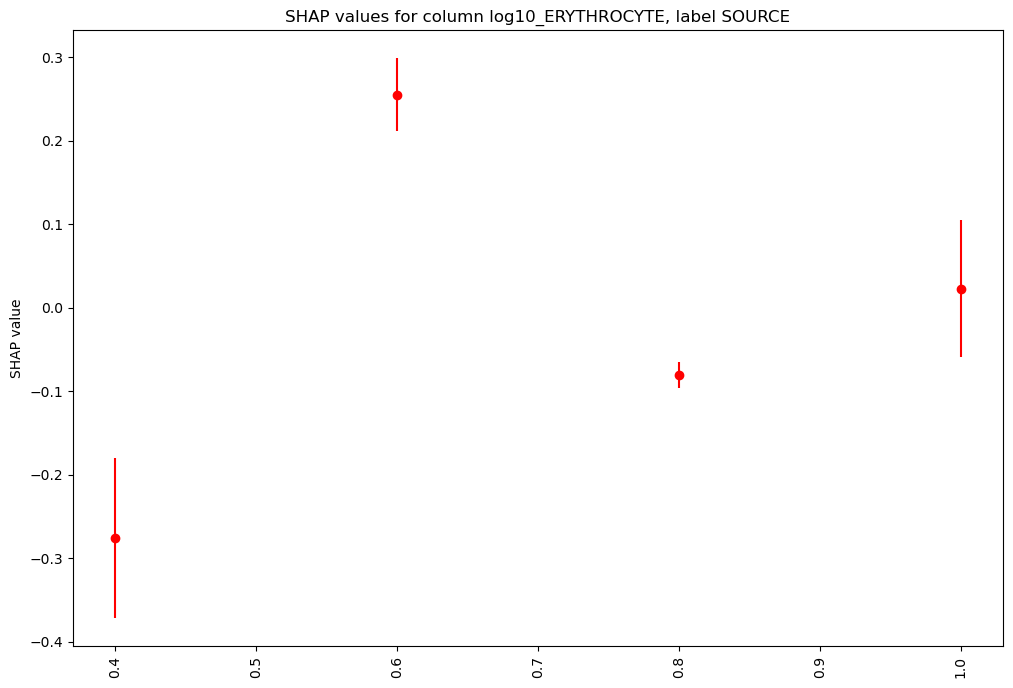

       gain  gain_std  count
col                         
0.6  0.2551    0.0436    519
1.0  0.0227    0.0823     14
0.8 -0.0802    0.0155   1668
0.4 -0.2759    0.0960      5

log10_LEUCOCYTE



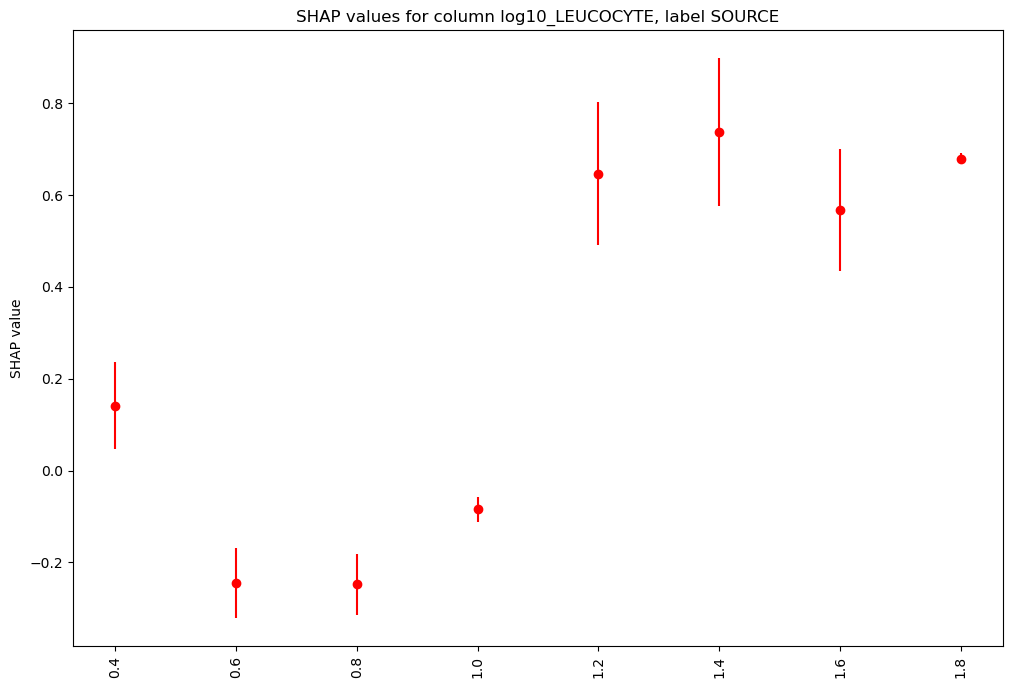

       gain  gain_std  count
col                         
1.4  0.7368    0.1611     82
1.8  0.6785    0.0118      2
1.2  0.6467    0.1551    320
1.6  0.5668    0.1323     13
0.4  0.1407    0.0949     35
1.0 -0.0841    0.0270    861
0.6 -0.2455    0.0760    198
0.8 -0.2478    0.0670    695

log10_THROMBOCYTE



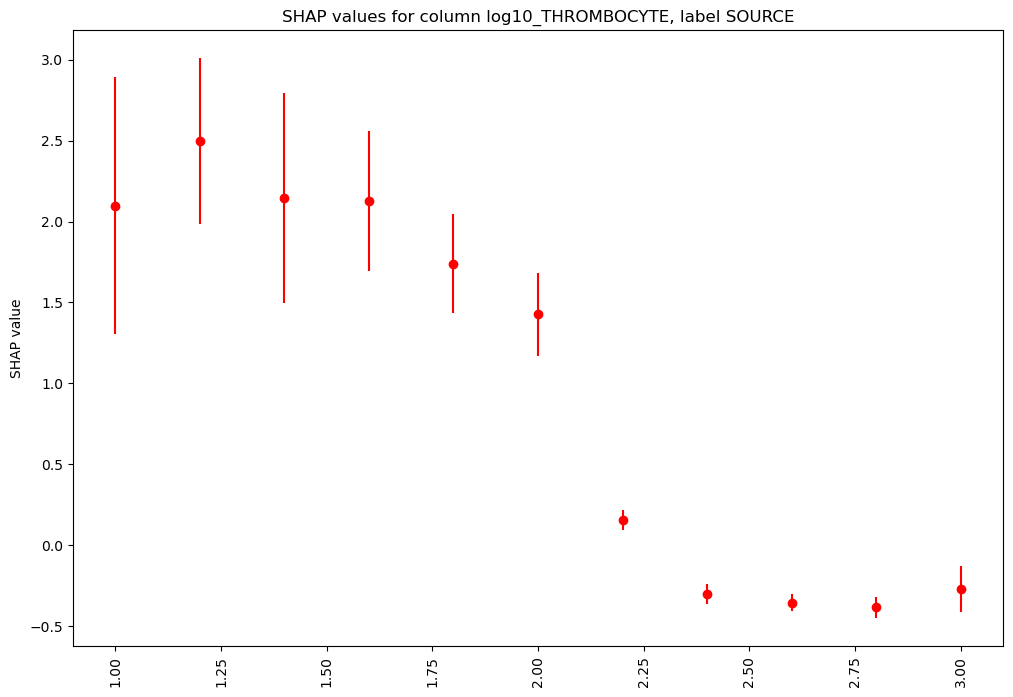

       gain  gain_std  count
col                         
1.2  2.4965    0.5117      7
1.4  2.1449    0.6498     21
1.6  2.1273    0.4322     26
1.0  2.0969    0.7934      3
1.8  1.7405    0.3039     65
2.0  1.4263    0.2563    121
2.2  0.1591    0.0611    362
3.0 -0.2697    0.1395      7
2.4 -0.2999    0.0608   1022
2.6 -0.3540    0.0532    535
2.8 -0.3830    0.0671     37

log10_MCH



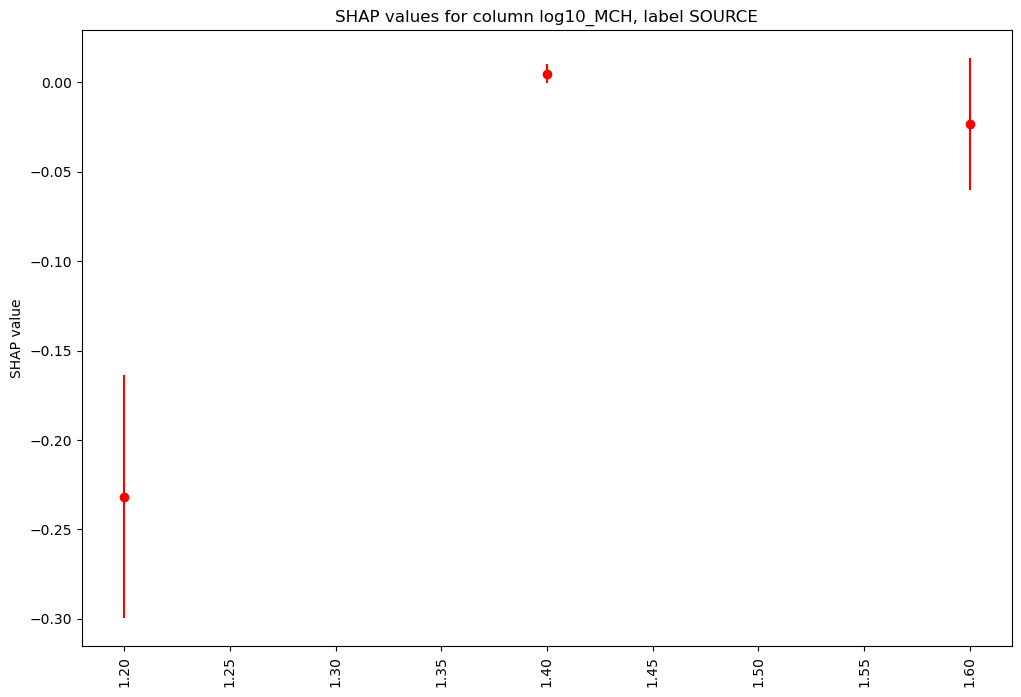

       gain  gain_std  count
col                         
1.4  0.0048    0.0053   1882
1.6 -0.0234    0.0368    304
1.2 -0.2317    0.0680     20

log10_MCHC



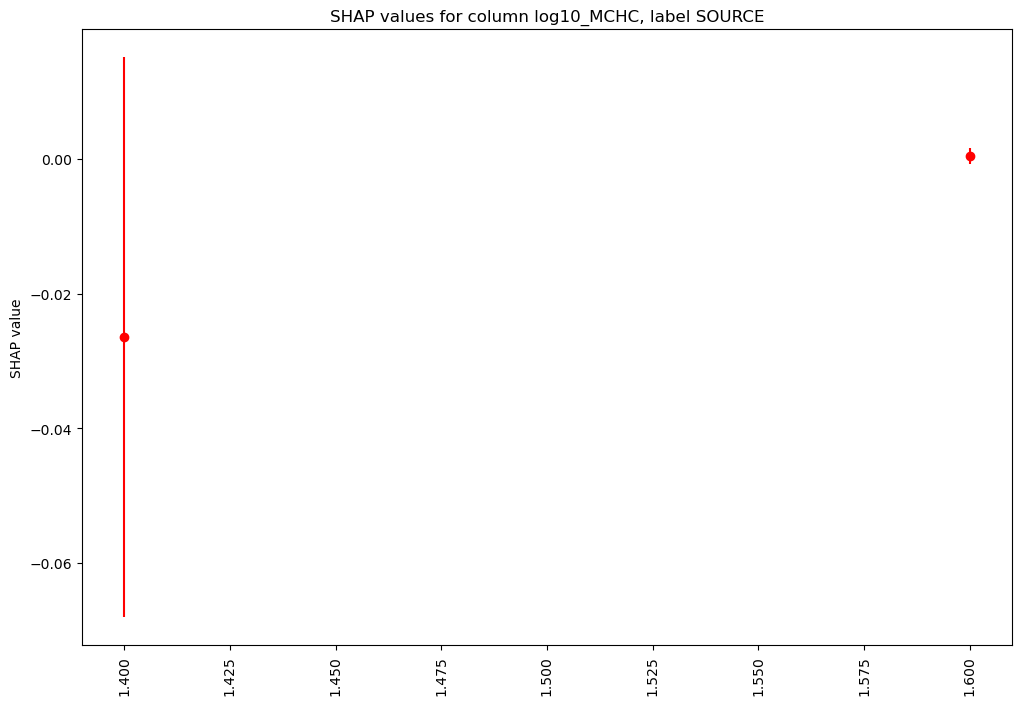

       gain  gain_std  count
col                         
1.6  0.0005    0.0012   2144
1.4 -0.0265    0.0416     62

log10_MCV



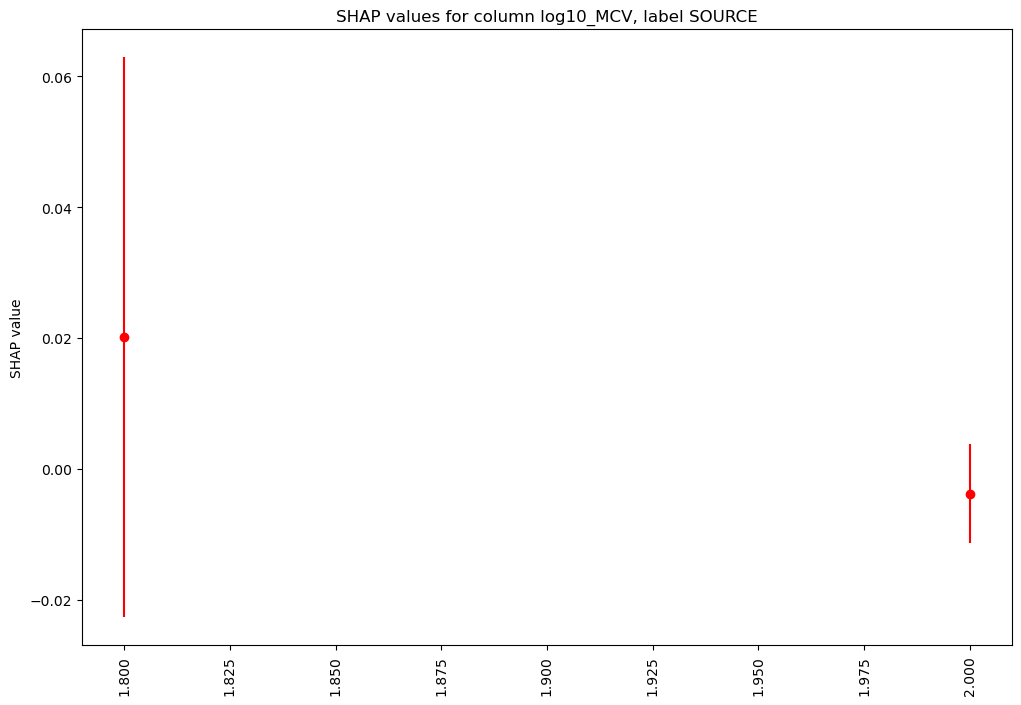

       gain  gain_std  count
col                         
1.8  0.0201    0.0428    323
2.0 -0.0038    0.0076   1883


In [12]:
def show_shap(col, shap_values=shap_values, label=main_label, X_test=X_test, ylabel='SHAP value'):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,df_infl.columns.tolist().index(col)]
    gain = round(df_infl.groupby(col).mean()['shap_'],4)
    gain_std = round(df_infl.groupby(col).std()['shap_'],4)
    cnt = df_infl.groupby(col).count()['shap_']
    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(12,8))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.title(f'SHAP values for column {col}, label {label}')
    plt.ylabel(ylabel)
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    print(df_res)
    return

for col in X_test.columns:
    print()
    print(col)
    print()
    show_shap(col, shap_values, label=main_label, X_test=X_test)